# Gliederung

<!-- 
    Frame the problem and look at the big picture.
    Get the data.
    Explore the data to gain insights.
    Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
    Explore many different models and short-list the best ones.
    Fine-tune your models and combine them into a great solution.
    Present your solution.
    Launch, monitor, and maintain your system.
-->

1. [Aufgabenstellung](#1-problem--aufgabenstellung)
2. [Import](#2-import)
3. [Exploration](3-#exploration).
4. [Vorbereitung / Feauture Engineering]()
5. [Modellierung]()
6. [Ergebnis]()


# 1. Problem / Aufgabenstellung

<!-- Frame the problem and look at the big picture. -->

Kategorien der Verbrechen in San Francisco sollen vorhergesagt werden.
Dabei werden die Kategorien *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* betrachtet

Zur Vorhersage soll **eine** dieser Methoden verwendet werden: Regression, Klassifikation oder Clustering



# 2. Import

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
colors = sns.color_palette(None, 5)
import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot as gplt
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPolygon

from meteostat import Point, Hourly

from itertools import product
from scipy import stats

from sklearn import tree
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\sampleSubmission.csv
data\SF Find Neighborhoods.geojson
data\test.csv
data\train.csv


In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
train['Dates'] = pd.to_datetime(train['Dates'])

print('First date: ', str(train['Dates'].min()))
print('Last date: ', str(train['Dates'].max()))
print('Train data shape: ', train.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Train data shape:  (878049, 9)


## Selektion

Die Daten werden so gefiltert, dass nur *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* als Kategorien vertreten sind.

In [5]:
train["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [6]:
categories = [i.upper() for i in ["Larceny/Theft", "Assault", "Drug/Narcotic", "Vehicle Theft", "Burglary"]]

train = train.loc[train["Category"].isin(categories)]

train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564


# 3. Exploration

## Datentypen

In [7]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

Hier kann man einige Datentypen konvertieren:

Dates -> DateTime
Category -> String
Descript -> String
DayOfWeek -> String
PdDistrict -> String
Resolution -> String


In [8]:
train["Dates"] = pd.to_datetime(train["Dates"])
train["YearMonth"] = train['Dates'].dt.strftime('%Y-%m')
train["Year"] = train['Dates'].dt.strftime('%Y')
train["Month"] = train['Dates'].dt.strftime('%m')
train["Day"] = train['Dates'].dt.strftime('%d')
train["TimeOfDay"] = train['Dates'].dt.strftime('%H')

## Duplikate


In [9]:
train.duplicated().sum()

923

In [10]:
train.drop_duplicates(inplace=True)

## Falsche Werte

Im nächsten Schritt wird betrachtet, ob die Koordinaten falsche Werte enthalten könnten.

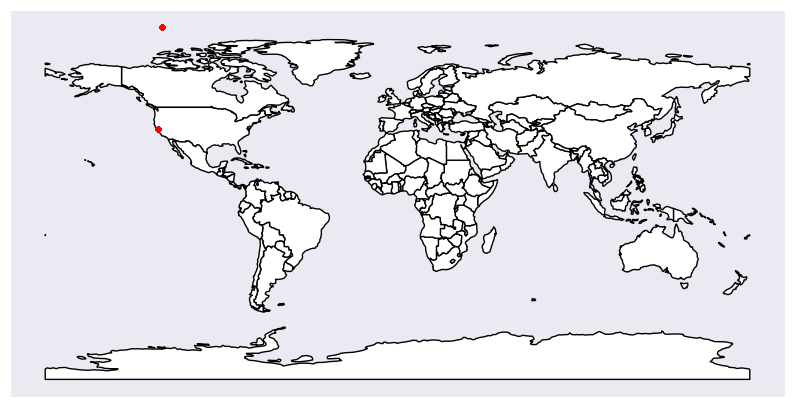

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns

def create_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs='epsg:4326')
    return gdf

# Assuming 'train' is your original DataFrame
train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 10))

world.plot(ax=ax, color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red', markersize=10)  # Adjust markersize as needed

ax.set_aspect('equal')

#sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

ax.set_xticks([])  # Use set_xticks to hide x-axis ticks
ax.set_yticks([])  # Use set_yticks to hide y-axis ticks


plt.show()


Ein Blick auf die Karte genügt um zu sehen, dass sich einige Punkte außerhalb der USA und außerhalb von San Fransisco befinden.

In [27]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

29


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,geometry
789255,2004-03-15 15:30:00,ASSAULT,BATTERY,Monday,INGLESIDE,JUVENILE BOOKED,PERSIA AV / LA GRANDE AV,-120.5,90.0,2004-03,2004,03,15,15,POINT (-120.50000 90.00000)
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,2005-12,2005,12,30,17,POINT (-120.50000 90.00000)
772431,2004-05-28 18:00:00,VEHICLE THEFT,"VEHICLE, RECOVERED, OTHER VEHICLE",Friday,SOUTHERN,NONE,BRYANT ST / SPEAR ST,-120.5,90.0,2004-05,2004,05,28,18,POINT (-120.50000 90.00000)
675070,2005-10-18 20:00:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,PARK,NONE,TURK ST / STJOSEPHS AV,-120.5,90.0,2005-10,2005,10,18,20,POINT (-120.50000 90.00000)
823378,2003-09-21 13:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,BAYVIEW,NONE,GILMAN AV / FITCH ST,-120.5,90.0,2003-09,2003,09,21,13,POINT (-120.50000 90.00000)


In [28]:
from sklearn.impute import SimpleImputer

In [29]:


train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

## Fehlende Werte

In [30]:
train.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
YearMonth     0
Year          0
Month         0
Day           0
TimeOfDay     0
dtype: int64

Wie oben zu sehen, gibt es keine fehlenden Werte in diesem Datensatz



## Deskriptive Statistik

### Balkendiagramme

#### Verbrechen je Bezirk

In [31]:
data_cat = train.groupby('Category').count().iloc[:, 0]. sort_values(ascending=False)
data = data_cat.reindex(np.append(np.delete(data_cat.index, 1), 'OTHER OFFENSES'))



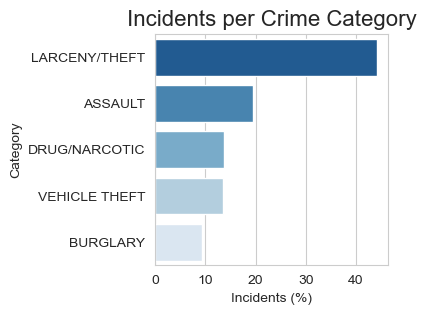

In [32]:
plt.figure(figsize=(3, 3))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x = (data_cat.values / data_cat.values.sum()) * 100,
        y = data_cat.index,
        orient='h',
        palette="Blues_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

In [33]:
data_cat.describe()

count         5.000000
mean      79072.000000
std       55129.968488
min       36600.000000
25%       53706.000000
50%       53919.000000
75%       76815.000000
max      174320.000000
Name: Dates, dtype: float64

### Histogramme

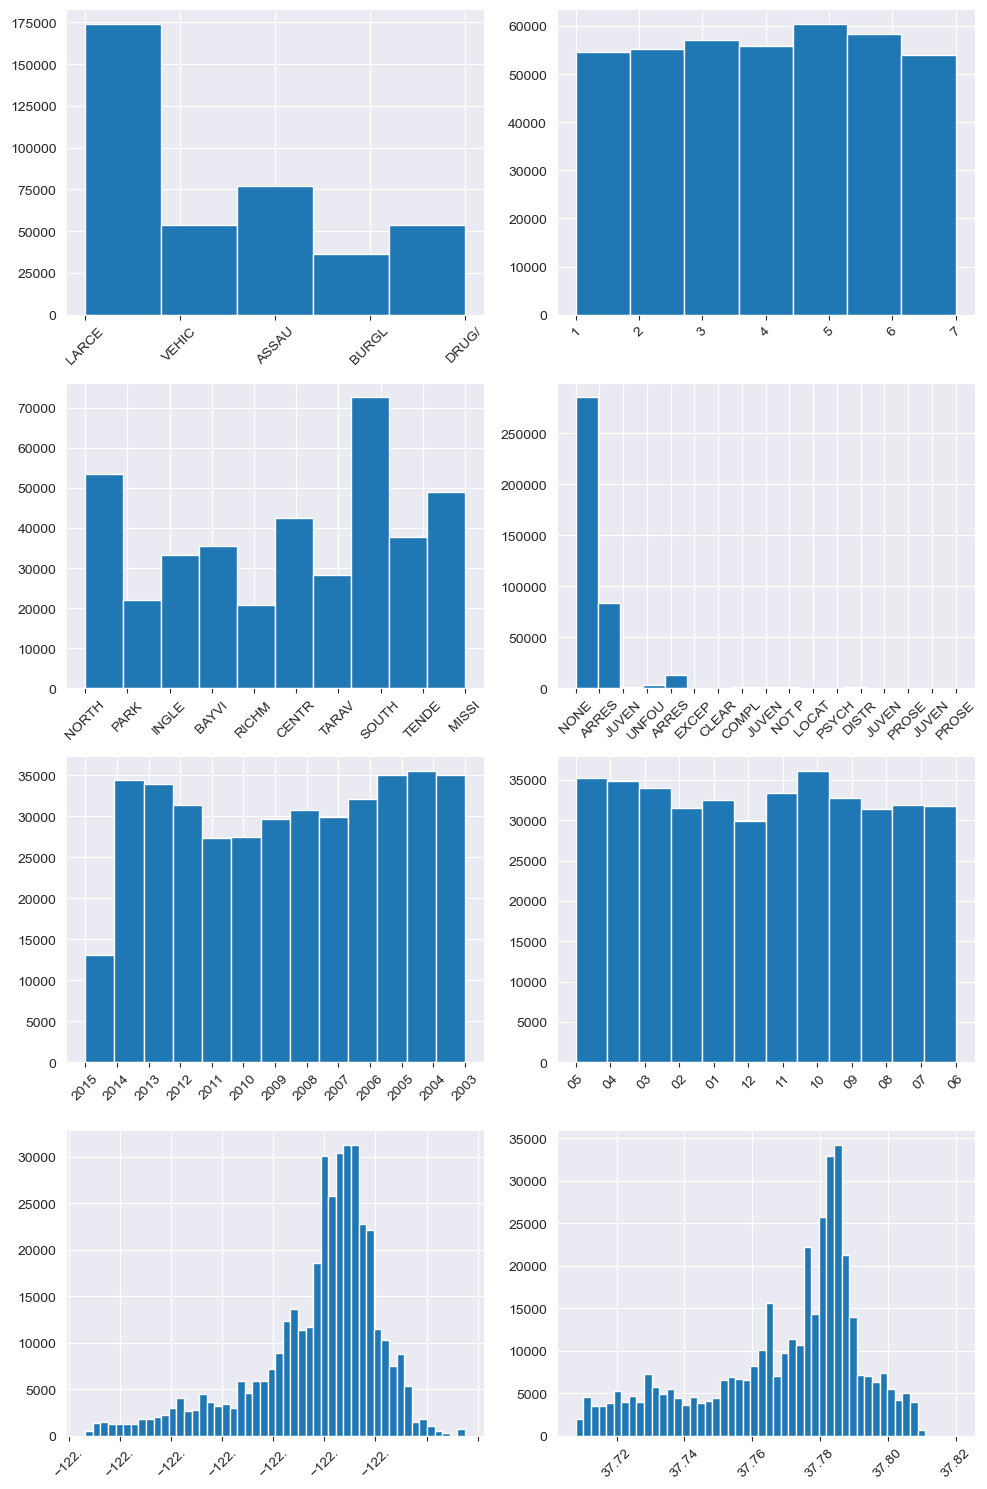

In [39]:


def truncate_label(label, length=5):
    return label[:length]

colors = sns.color_palette(None, 3)
columns = ["DayOfWeek", "PdDistrict", "Resolution"]


fig, axes = plt.subplots(4, 2, figsize = (10, 15), tight_layout=True)

axes[0, 0].hist(train["Category"], bins=5, align="mid")

#Tag der Woche als Zahl für Sortierung der Balken
axes[0, 1].hist(train['Dates'].dt.weekday + 1, bins=7, align="mid")

axes[1, 0].hist(train["PdDistrict"], align="mid", bins=len(train["PdDistrict"].unique()))
axes[1, 1].hist(train["Resolution"], align="mid", bins=len(train["Resolution"].unique()))
axes[2, 0].hist(train["Year"], bins=13, align="mid")
axes[2, 1].hist(train["Month"], bins=12, align="mid")
axes[3, 0].hist(train["X"], align="mid", bins=50)
axes[3, 1].hist(train["Y"], align="mid", bins=50)

# Rotate x-axis tick labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_ticks_position('bottom')  # Place ticks at the bottom for better visibility
    ax.set_xticklabels([truncate_label(label.get_text()) for label in ax.get_xticklabels()])

plt.tight_layout()

plt.show()

### Zeitliche Regression

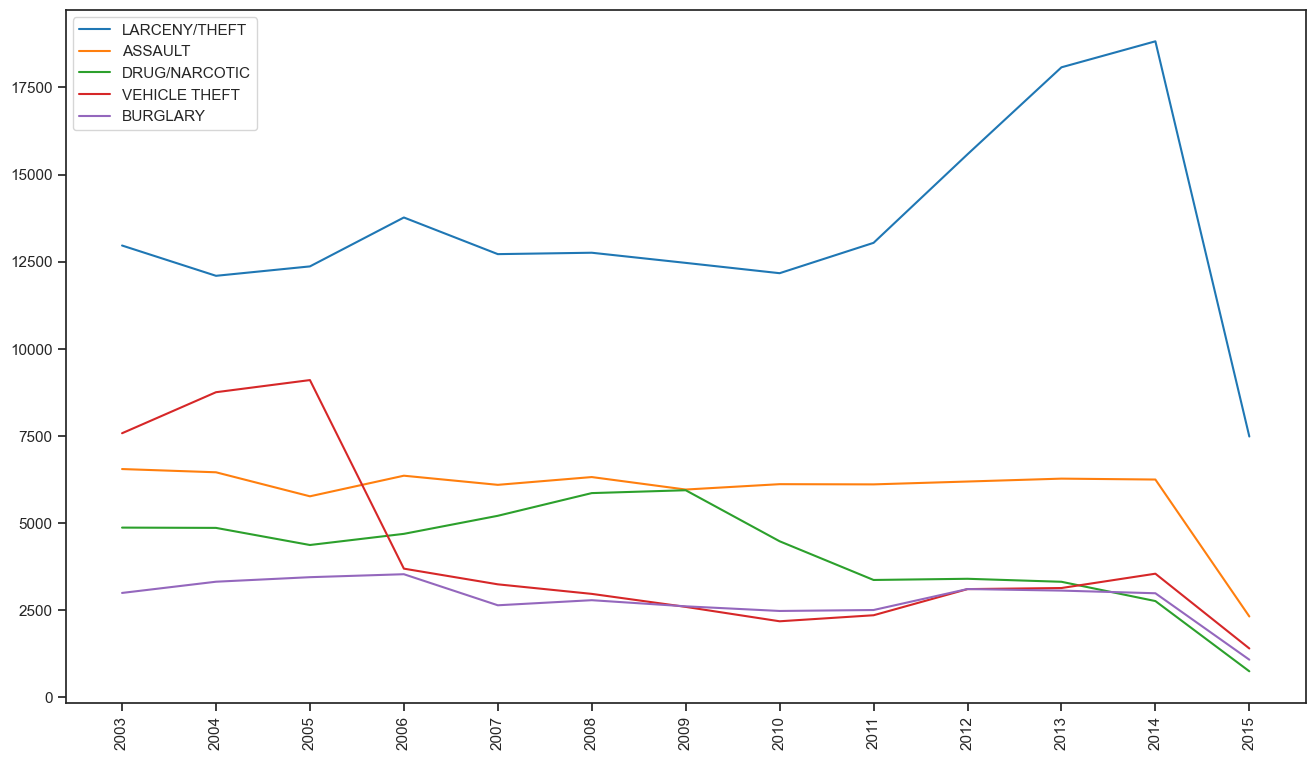

In [40]:
sns.set_style("ticks")
sns.set_context('notebook', font_scale = 1)

train_year_cat = train.groupby(by=["Year", "Category"], as_index=False).count()
data = train_year_cat.pivot_table(index="Year", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix, rotation=90, ha="center")
plt.show()


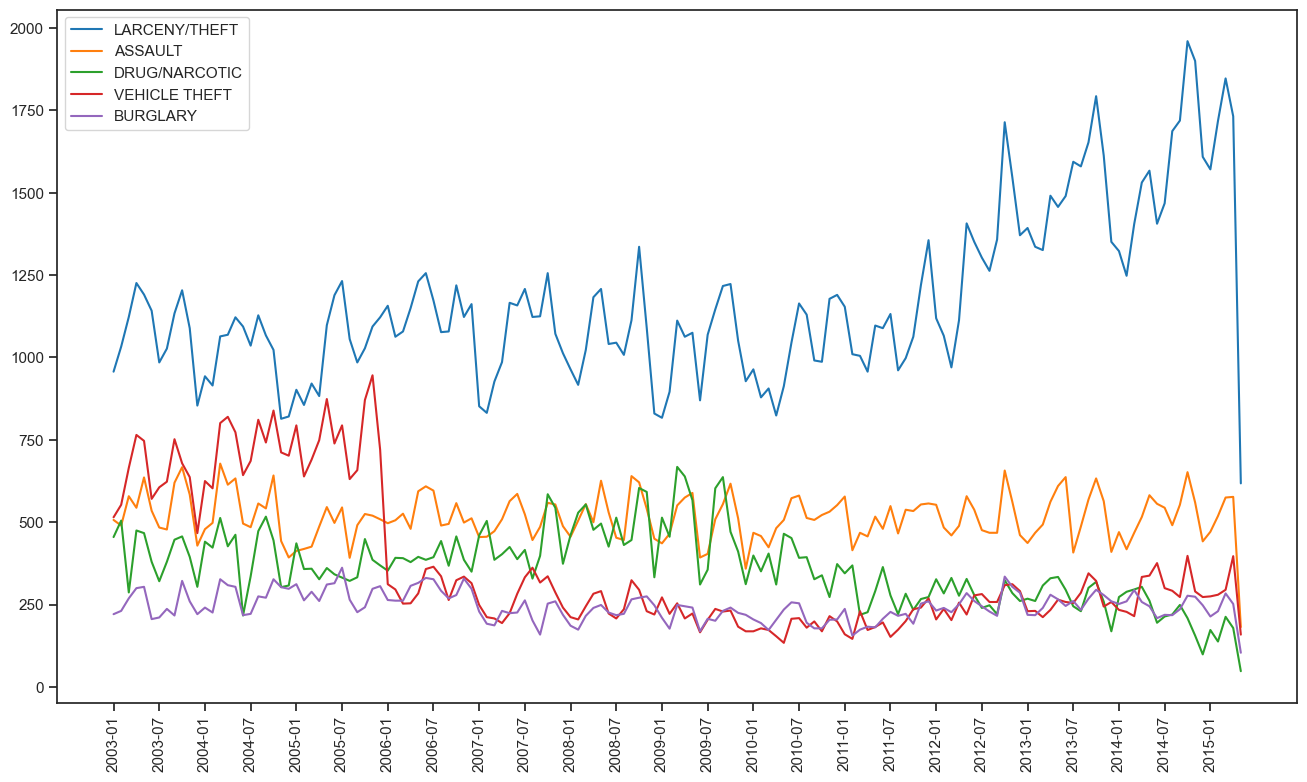

In [41]:
train_yearmonth_cat = train.groupby(by=["YearMonth", "Category"], as_index=False).count()
data = train_yearmonth_cat.pivot_table(index="YearMonth", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix[::6], rotation=90, ha="center")
plt.show()

### Kartogramme

In [42]:

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(train.X, train.Y)]
train_gdf = GeoDataFrame(train, crs="EPSG:4326", geometry=geometry)


point = train_gdf
poly  = sf_df

pointInPolys = sjoin(point, poly, how='left')
grouped = pointInPolys.groupby('index_right').count()


Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs



In [43]:
heat_districts = pointInPolys.groupby('index_right')["Dates"].count()
heat_districts

index_right
0.0       239
1.0       450
2.0        36
3.0       465
4.0      5046
         ... 
112.0     579
113.0     591
114.0    1664
115.0     226
116.0     191
Name: Dates, Length: 117, dtype: int64

In [44]:

geom = sf_df.pop('geometry')
sf_df = sf_df.join(geom, how='inner')
sf_df["polygons"] = ""
for i,row in sf_df.iterrows():
    geometry = row["geometry"]
    if geometry.geom_type == 'MultiPolygon':
        polygons = []
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            interior_coords = [list(interior.coords) for interior in polygon.interiors]
            polygons.append(Polygon(exterior_coords, interior_coords))
    else:
        polygons = [Polygon(list(geometry.exterior.coords))]
    sf_df.at[i, "polygons"] = polygons

sf_df["polygons"] = sf_df["polygons"].explode()

sf_df["index_right"] = sf_df.index
sf_df["heat"] = sf_df.merge(heat_districts, on="index_right")["Dates"]
sf_df["geometry"] = sf_df["polygons"]

gdf = gpd.GeoDataFrame(sf_df)




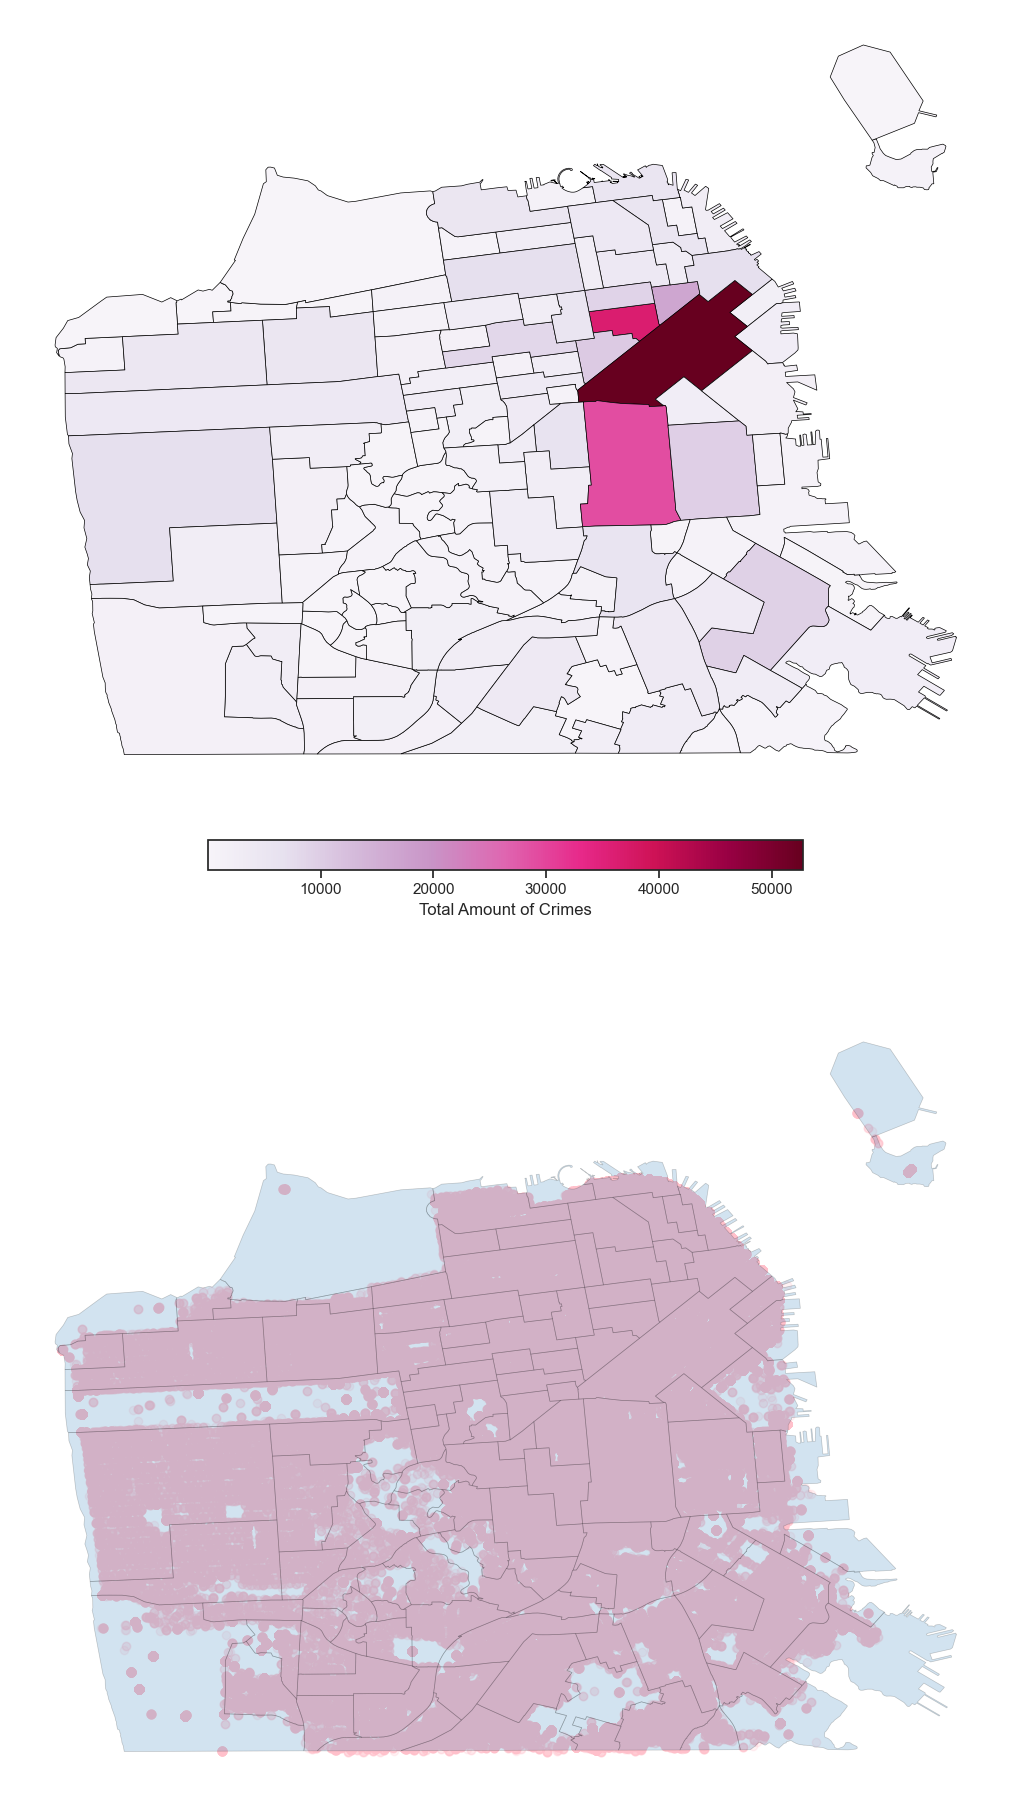

In [45]:
fig, ax = plt.subplots(2,1,figsize=(10, 20), layout='constrained')

gdf.plot(ax=ax[0], alpha=1, edgecolor='k', linewidth=0.5, column="heat", cmap="PuRd")
cbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation="horizontal", shrink=0.6)
cbar.set_label("Total Amount of Crimes")

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})
sf_df.plot(ax=ax[1], alpha=0.2, edgecolor='k', linewidth=0.5, zorder=2)
ax[1].scatter(data=train.loc[train["Y"]<80], x="X", y="Y",alpha=0.2, color="pink", zorder=1)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

sns.despine(ax=ax[0], left=True, right=True, top=True, bottom=True)
sns.despine(ax=ax[1], left=True, right=True, top=True, bottom=True)

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])    
    
plt.show()



### Korrelation

#### Korrelation zwischen Kategorien und Bezirken

In [46]:
df_district_cat = pd.crosstab(train['Category'], train['PdDistrict'])
df_district_cat.head()

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,9845,6971,8522,11146,8312,3512,3198,12175,5460,7674
BURGLARY,3914,4499,3327,3736,5827,2875,2683,4796,3459,1484
DRUG/NARCOTIC,4496,1805,2372,8750,4508,2570,999,9222,1529,17668
LARCENY/THEFT,10075,24973,10207,18201,28566,9118,9845,41660,11807,9868
VEHICLE THEFT,7199,4208,8950,7134,6286,3955,4114,4722,6133,1005


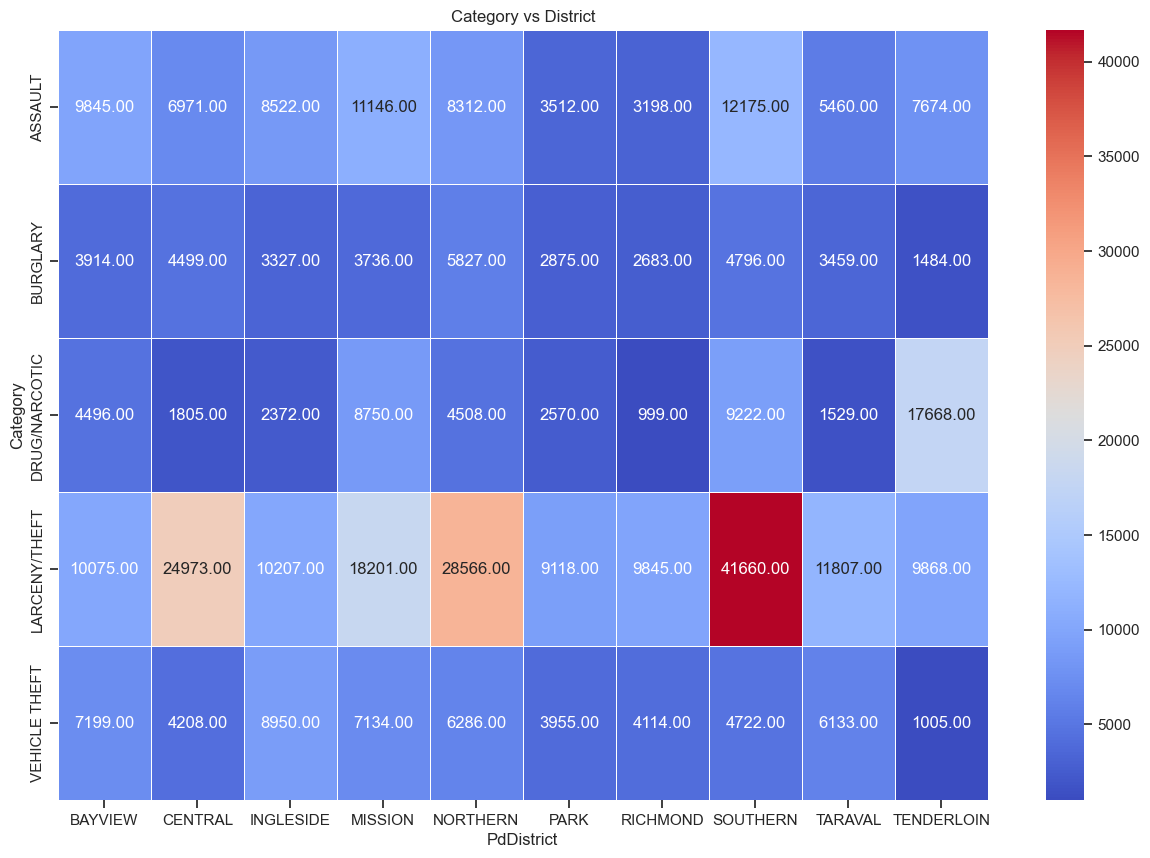

In [47]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_cat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs District')
plt.show()

#### Korrelation zwischen den kategorischen Spalten

In [48]:
unique_val_col = pd.DataFrame(train.nunique())
corr_columns = list(unique_val_col.loc[unique_val_col[0] <= 250].index)
corr_columns.remove("DayOfWeekId")
print(corr_columns)

['Category', 'DayOfWeek', 'PdDistrict', 'Resolution', 'YearMonth', 'Year', 'Month', 'Day', 'TimeOfDay']


In [49]:

x = [i[0] for i in product(corr_columns, corr_columns)]
y = [i[1] for i in product(corr_columns, corr_columns)]


corr_df = pd.DataFrame(index=corr_columns, columns=corr_columns)

for i in range(0,len(x)):
    if x[i] == y[i]:
        corr_df.loc[x[i], y[i]] = 1
        corr_df.loc[y[i], x[i]] = 1
    if pd.isnull(corr_df.loc[x[i], y[i]]):
        temp_ct = pd.crosstab(train[x[i]], train[y[i]])
        
        X2 = stats.chi2_contingency (temp_ct, correction= False )[0]
        n = sum(temp_ct.sum())
        minDim = min( temp_ct.shape )-1
        
        V = np.sqrt((X2/n) / minDim)
        
        corr_df.loc[x[i], y[i]] = V
        corr_df.loc[y[i], x[i]] = corr_df.loc[x[i], y[i]]

Cramér, H. (1946). Mathematical Methods of Statistics. Princeton: Princeton University Press, p. 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6.

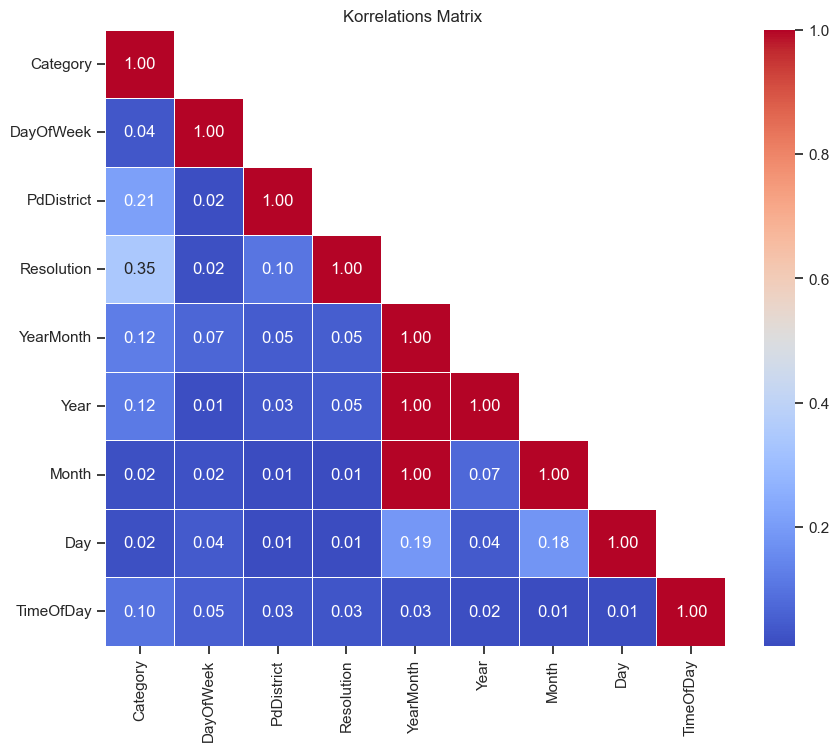

In [50]:
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

## Feature Engineering

An dieser Stelle werden neue Spalten generiert, die den Datensatz bereichern und den Modellen helfen können.

### Feiertage

In [51]:
import holidays

usa_holidays = pd.Series(holidays.country_holidays('US',  years=range(train["Dates"].dt.year.min(), train["Dates"].dt.year.max())))

usa_holidays = pd.DataFrame(usa_holidays)
usa_holidays.columns = ["Holiday"]
usa_holidays["YearMonthDay"] = pd.to_datetime(usa_holidays.index)
usa_holidays.reset_index(drop=True)

train["YearMonthDay"] = pd.to_datetime(train['Dates'].dt.strftime('%Y-%m-%d'))
train = train.merge(usa_holidays, on="YearMonthDay", how="left")

train["Holiday"].fillna("None", inplace=True)

In [52]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,DayOfWeekId,YearMonthDay,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015,05,13,23,3,2015-05-13,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015,05,13,23,3,2015-05-13,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015,05,13,23,3,2015-05-13,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015,05,13,23,3,2015-05-13,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015,05,13,23,3,2015-05-13,None


In [53]:
df_district_holiday = pd.crosstab(train['Category'], train['Holiday'])
df_district_holiday = df_district_holiday.loc[:, df_district_holiday.columns != 'None']
df_district_holiday.head()

Holiday,Christmas Day,Christmas Day (Observed),Columbus Day,Independence Day,Independence Day (Observed),Labor Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Day (Observed),Thanksgiving,Veterans Day,Veterans Day (Observed),Washington's Birthday
Category,,,,,,,,,,,,,,
ASSAULT,201,86,185,42,43,386,179,378,198,37,170,191,52,335
BURGLARY,117,47,110,16,13,102,92,151,45,10,98,80,34,166
DRUG/NARCOTIC,65,32,166,11,13,272,202,271,54,13,86,175,43,313
LARCENY/THEFT,368,183,516,57,60,726,458,687,241,76,319,463,157,753
VEHICLE THEFT,153,90,146,17,42,218,133,217,43,14,111,159,32,250


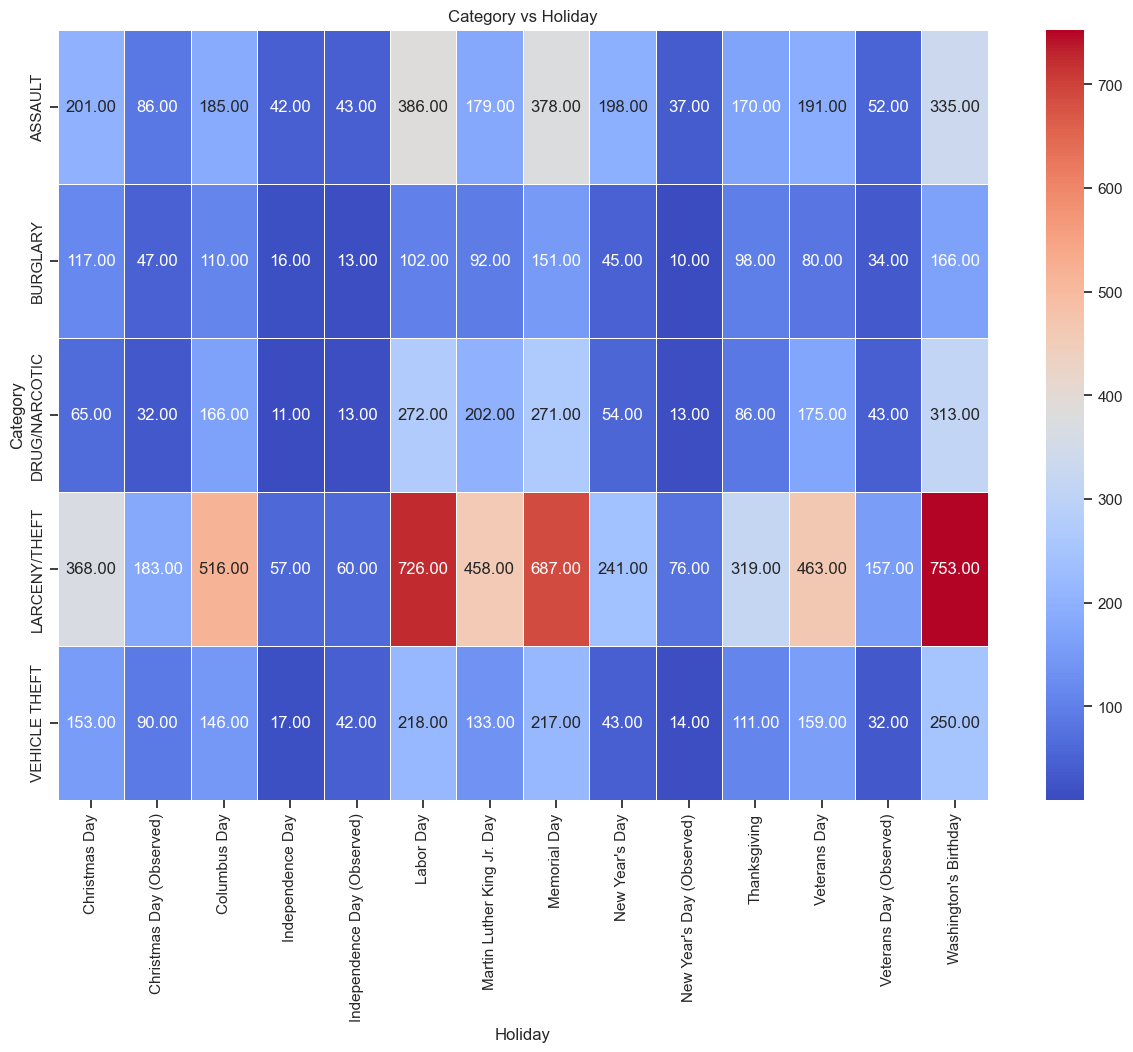

In [55]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_holiday, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Category vs Holiday')
plt.show()

### Wetter

In [56]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,Year,Month,Day,TimeOfDay,DayOfWeekId,YearMonthDay,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015,05,13,23,3,2015-05-13,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015,05,13,23,3,2015-05-13,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015,05,13,23,3,2015-05-13,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015,05,13,23,3,2015-05-13,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015,05,13,23,3,2015-05-13,None


In [57]:
train["hours"] = pd.to_datetime(train['Dates'].dt.strftime('%Y-%m-%d %H'))

In [58]:
from meteostat import Point, Hourly
import pandas as pd
import matplotlib.pyplot as plt

start_date = train['Dates'].min()
end_date = train['Dates'].max()

san_francisco = Point(37.7749, -122.4194, 10)

# Get hourly data for the specified date range
sf_weather = pd.DataFrame(Hourly(san_francisco, start_date, end_date).fetch())

sf_weather["hours"] = pd.to_datetime(sf_weather.index.strftime('%Y-%m-%d %H'))
train = train.merge(sf_weather, how="left", on="hours")

In [61]:
train.describe()

,Dates,X,Y,DayOfWeekId,YearMonthDay,hours,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,395360,395360.000000,395360.000000,395360.000000,395360,395360,395354.000000,395354.000000,395354.000000,391008.000000,0.0,378674.000000,395354.000000,0.0,395354.000000,0.0,0.0
mean,2009-02-10 07:21:34.632638464,-122.422927,37.768872,4.020374,2009-02-09 17:05:35.087009024,2009-02-10 07:03:04.261432832,14.355385,9.080500,72.988772,0.052628,NaN,229.155712,12.871729,NaN,1017.067777,NaN,NaN
min,2003-01-06 00:01:00,-122.513642,37.707920,1.000000,2003-01-06 00:00:00,2003-01-06 00:00:00,-1.700000,-15.800000,8.000000,0.000000,NaN,10.000000,0.000000,NaN,995.700000,NaN,NaN
25%,2005-10-22 22:56:15,-122.433010,37.755456,2.000000,2005-10-22 00:00:00,2005-10-22 22:45:00,11.700000,6.800000,63.000000,0.000000,NaN,180.000000,7.600000,NaN,1013.900000,NaN,NaN
50%,2008-12-25 01:32:30,-122.416650,37.776044,4.000000,2008-12-25 00:00:00,2008-12-25 01:00:00,14.000000,9.900000,75.000000,0.000000,NaN,260.000000,11.200000,NaN,1016.700000,NaN,NaN
75%,2012-06-25 18:18:45,-122.407149,37.785103,6.000000,2012-06-25 00:00:00,2012-06-25 18:00:00,17.200000,12.000000,86.000000,0.000000,NaN,290.000000,18.400000,NaN,1020.000000,NaN,NaN
max,2015-05-13 23:30:00,-122.364937,37.819975,7.000000,2015-05-13 00:00:00,2015-05-13 23:00:00,36.700000,21.100000,100.000000,14.200000,NaN,360.000000,64.800000,NaN,1034.800000,NaN,NaN
std,NaN,0.025085,0.023804,1.978628,NaN,NaN,4.611076,4.073984,16.490254,0.386137,NaN,86.096953,9.063958,NaN,4.664423,NaN,NaN


### Straßen

In [62]:
is_block = train["Address"].str.contains(" /")
train.loc[is_block, "Street/Block"] = train.loc[is_block, "Address"].copy()

is_street = train["Address"].str.contains(" of ")
train.loc[is_street, "Street/Block"] = train.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()

train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,YearMonth,...,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Street/Block
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,...,48.0,0.0,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,LOMBARD ST
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,...,48.0,0.0,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,BRODERICK ST
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,...,48.0,0.0,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,TEDDY AV
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,...,48.0,0.0,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,AVALON AV / PERU AV
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,...,48.0,0.0,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,KIRKWOOD AV / DONAHUE ST


In [63]:
train["Street/Block"].unique()

array(['LOMBARD ST', 'BRODERICK ST', 'TEDDY AV', ...,
       'ALERT AL / DOLORES ST', 'FOLSOM ST / ZENO PL',
       '35TH AV / ANZA ST'], dtype=object)

In [64]:
str_cat_ct = pd.crosstab(train["Street/Block"], train["Category"], margins=True, margins_name="Total")

str_cat_ct = str_cat_ct[str_cat_ct.index != "Total"]
top_ten_str = str_cat_ct.sort_values(by="Total", ascending=False).head(10)
top_ten_str

Category,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,VEHICLE THEFT,Total
Street/Block,,,,,,
MARKET ST,2190,1245,2270,7660,196,13561
MISSION ST,2932,849,3061,3861,493,11196
BRYANT ST,2086,555,821,6681,313,10456
TURK ST,1181,265,2421,657,154,4678
OFARRELL ST,821,498,725,2376,249,4669
ELLIS ST,1027,231,1904,733,143,4038
EDDY ST,1379,329,1015,801,139,3663
POST ST,408,418,216,1793,162,2997
POWELL ST,470,264,113,2067,61,2975


<Axes: xlabel='Street/Block'>

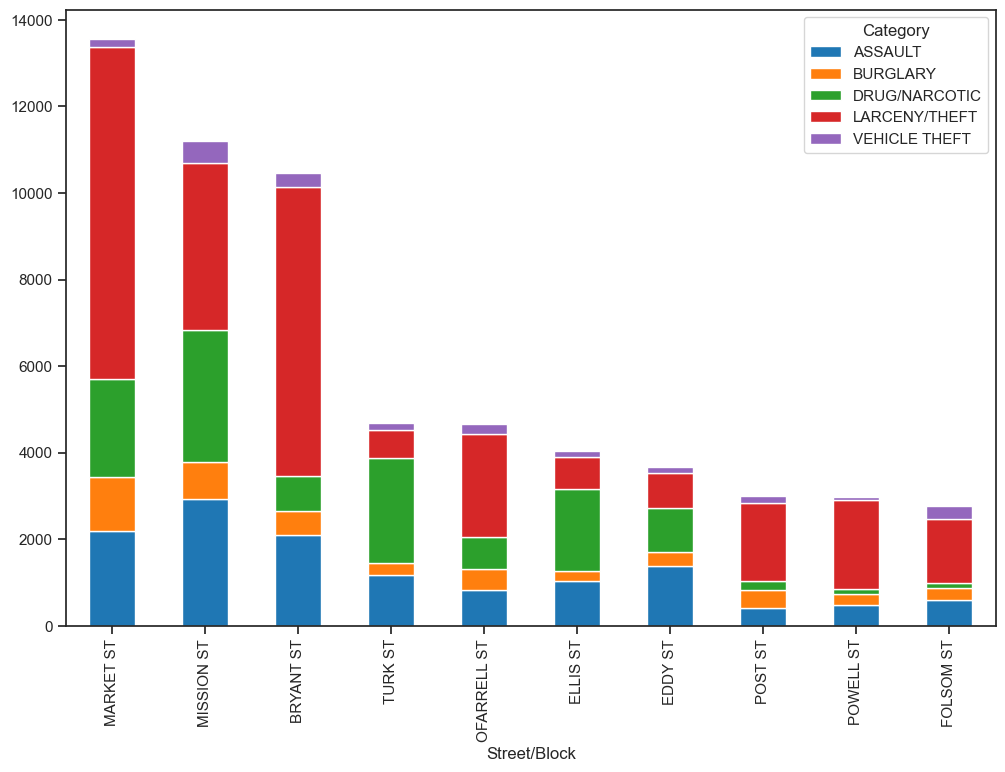

In [65]:
top_ten_str.drop('Total', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8))

# 4. Vorbereitung

Anhand der Korrelation können wir ablesen, welche Spalten den größten Einfluss auf die Kategorie hat, welche wir letztendlich vorhersagen wollen.

In [66]:
corr_df["Category"]


Category      1.000000
DayOfWeek     0.035553
PdDistrict    0.213927
Resolution    0.346102
YearMonth     0.123634
Year          0.116026
Month         0.018412
Day           0.018449
TimeOfDay     0.099247
Name: Category, dtype: float64

Im nächsten Schritt werden die Spalten ausgewählt, welche mindestens eine Korrelation von 0.05 haben


Da Year und YearMonth fast die gleiche Korrelation mit Category haben und untereinander eine sehr hohe Korrelation haben, 
beschränken wir uns auf YearMonth und filtern Year raus. 

<!-- Resolution ist leider nicht in den Test-Daten vorhanden, daher nützt es nichts die Modelle mit dieser Spalte zu trainieren und sie wird ebenfalls entfernt.  -->

Und da wir Category vorhersagen sollen, wird es auch im Training nicht berücksichtigt

In [67]:
onehot_cols = list(corr_df["Category"].loc[corr_df["Category"] >= 0.05].index)
onehot_cols.remove("Year")
onehot_cols.remove("Category")

#Obwohl Resolution für die Kaggle-Challange nicht verwendet werden darf, darf es im Rahmen des Projekts zur Klassifikation dienen.
#onehot_cols.remove("Resolution")

onehot_cols

['PdDistrict', 'Resolution', 'YearMonth', 'TimeOfDay']

## One-Hot-Encoding

In [68]:
train_dummies = pd.get_dummies(data=train, columns=onehot_cols, dtype=float, prefix=["_" + i for i in onehot_cols])
train_dummies.head()

,Dates,Category,Descript,DayOfWeek,Address,X,Y,Year,Month,Day,...,_TimeOfDay_14,_TimeOfDay_15,_TimeOfDay_16,_TimeOfDay_17,_TimeOfDay_18,_TimeOfDay_19,_TimeOfDay_20,_TimeOfDay_21,_TimeOfDay_22,_TimeOfDay_23
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,05,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,100 Block of BRODERICK ST,-122.438738,37.771541,2015,05,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,0 Block of TEDDY AV,-122.403252,37.713431,2015,05,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,AVALON AV / PERU AV,-122.423327,37.725138,2015,05,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015,05,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Für Clustering Algorithmen müssen die Daten skaliert werden

In [69]:
from sklearn.preprocessing import StandardScaler
train_dummies_scaled = train_dummies.copy()
train_dummies_scaled[list(train_dummies.filter(like='_', axis=1).columns)] = StandardScaler().fit_transform(train_dummies[list(train_dummies.filter(like='_', axis=1).columns)])
train_dummies_scaled.head()

,Dates,Category,Descript,DayOfWeek,Address,X,Y,Year,Month,Day,...,_TimeOfDay_14,_TimeOfDay_15,_TimeOfDay_16,_TimeOfDay_17,_TimeOfDay_18,_TimeOfDay_19,_TimeOfDay_20,_TimeOfDay_21,_TimeOfDay_22,_TimeOfDay_23
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,05,13,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,100 Block of BRODERICK ST,-122.438738,37.771541,2015,05,13,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,0 Block of TEDDY AV,-122.403252,37.713431,2015,05,13,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,AVALON AV / PERU AV,-122.423327,37.725138,2015,05,13,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015,05,13,...,-0.23319,-0.242895,-0.249786,-0.26537,-0.278422,-0.26353,-0.247417,-0.23894,-0.240492,4.35658


## Aufteilung in Trainings- und Test-Daten

In [70]:
X, y = train_dummies.filter(like='_', axis=1), train_dummies["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 5. Modellierung

Bevor wir in die Modellierung tiefer einsteigen blicken wir einmal grob auf die möglichen Modelle und betrachten deren Genauigkeit bei Standardeinstellungen

## Decision Tree

In [71]:
dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, dt_clf.predict(X_test))

0.5167740995945397

In [72]:
X_test.head(1)

,_PdDistrict_BAYVIEW,_PdDistrict_CENTRAL,_PdDistrict_INGLESIDE,_PdDistrict_MISSION,_PdDistrict_NORTHERN,_PdDistrict_PARK,_PdDistrict_RICHMOND,_PdDistrict_SOUTHERN,_PdDistrict_TARAVAL,_PdDistrict_TENDERLOIN,...,_TimeOfDay_14,_TimeOfDay_15,_TimeOfDay_16,_TimeOfDay_17,_TimeOfDay_18,_TimeOfDay_19,_TimeOfDay_20,_TimeOfDay_21,_TimeOfDay_22,_TimeOfDay_23
123835,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
y_test.head(5)

123835          ASSAULT
212468          ASSAULT
226049    LARCENY/THEFT
119794    LARCENY/THEFT
54629     DRUG/NARCOTIC
Name: Category, dtype: object

In [74]:
dt_clf.predict(X_test.head(5))

array(['LARCENY/THEFT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'ASSAULT',
       'DRUG/NARCOTIC'], dtype=object)

In [75]:
# Output: ACHTUNG, SEHR SEHR LANGSAM 

# feature_names = list(train_dummies.filter(like='_', axis=1).columns)
# feature_names = [i.split("_")[2] for i in feature_names]

# tree.plot_tree(
#     clf,
#     proportion=True,
#     feature_names=feature_names,
#     class_names=list(clf.classes_),
#     label="none",
#     filled=True,
#     impurity=False
# )
# plt.figure(figsize=(10,20))
# plt.rcParams["figure.dpi"] = 300
# plt.show()

## K-Nearest-Neighbors (kNN)

In [76]:
from sklearn.neighbors import KNeighborsClassifier
X, y = train_dummies_scaled.filter(like='_', axis=1), train_dummies_scaled["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

knn_clf = KNeighborsClassifier(algorithm="ball_tree", n_neighbors=3)
knn_clf.fit(X_train, y_train)

#Der Predictor braucht sehr sehr lange, daher wurde nur mit 500 Zeilen gearbeitet
sample_index = list(y_test.sample(500, random_state=1).index)
accuracy_score(y_test.loc[sample_index], knn_clf.predict(X_test.loc[sample_index]))

0.442

## Support Vector Machines

In [77]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

svm_clf = LinearSVC(dual="auto", random_state=0, tol=1e-5)
svm_clf.fit(X_train, y_train)

accuracy_score(y_test, svm_clf.predict(X_test))

0.5525987016072783

## Zwischenfazit

Nach grober Betrachtung der Genauigkeiten der Modelle gibt es einen vorläufigen Gewinner

<br>

| Model                   | Genauigkeit |
|-------------------------|-------------|
| Support Vector Machines | 0.517       |
| Decision Tree           | 0.442       |
| K-Nearest-Neighbors     | 0.553       |

# 6. Ergebnis